In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/laps/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
EXPERIMENT_NAME = "library_evaluation_multi"

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [7]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=True,
    batch_size = "all",
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/library_evaluation_multi
Available domains: ['re2', 'clevr']


### Tasks solved vs. search time

In [17]:
df_search_time = analyzer.get_search_time_results()
df_search_time

Using enumeration_timeout: 1000
Using enumeration_timeout: 600


,time,n_solved,percent_solved,experiment_type,seed,iteration,split,domain
0,0,0,0.0,baseline_dreamcoder,111,15,test,re2
1,1,0,0.0,baseline_dreamcoder,111,15,test,re2
2,2,0,0.0,baseline_dreamcoder,111,15,test,re2
3,3,0,0.0,baseline_dreamcoder,111,15,test,re2
4,4,0,0.0,baseline_dreamcoder,111,15,test,re2
...,...,...,...,...,...,...,...,...
44449,596,0,0.0,gpt_solver_stitch_namer_search,333,9,train,clevr
44450,597,0,0.0,gpt_solver_stitch_namer_search,333,9,train,clevr
44451,598,0,0.0,gpt_solver_stitch_namer_search,333,9,train,clevr
44452,599,0,0.0,gpt_solver_stitch_namer_search,333,9,train,clevr


In [18]:
df_search_time["experiment_type"] = df_search_time["experiment_type"].replace({"gpt_solver": "base_dsl"})

In [27]:
analyzer.format_dataframe_camera(df_search_time[df_search_time.split == "test"])

,time,n_solved,Tasks solved (%),Model,seed,iteration,split,domain
6307,301,51,10.200000,Base DSL,111,15,test,REGEX
6210,204,30,6.000000,Base DSL,111,15,test,REGEX
6209,203,30,6.000000,Base DSL,111,15,test,REGEX
6208,202,30,6.000000,Base DSL,111,15,test,REGEX
6207,201,30,6.000000,Base DSL,111,15,test,REGEX
...,...,...,...,...,...,...,...,...
26028,2,0,0.000000,LILO (+ Search),222,15,test,REGEX
26029,3,0,0.000000,LILO (+ Search),222,15,test,REGEX
26030,4,6,1.200000,LILO (+ Search),222,15,test,REGEX
25020,996,357,71.400000,LILO (+ Search),111,15,test,REGEX


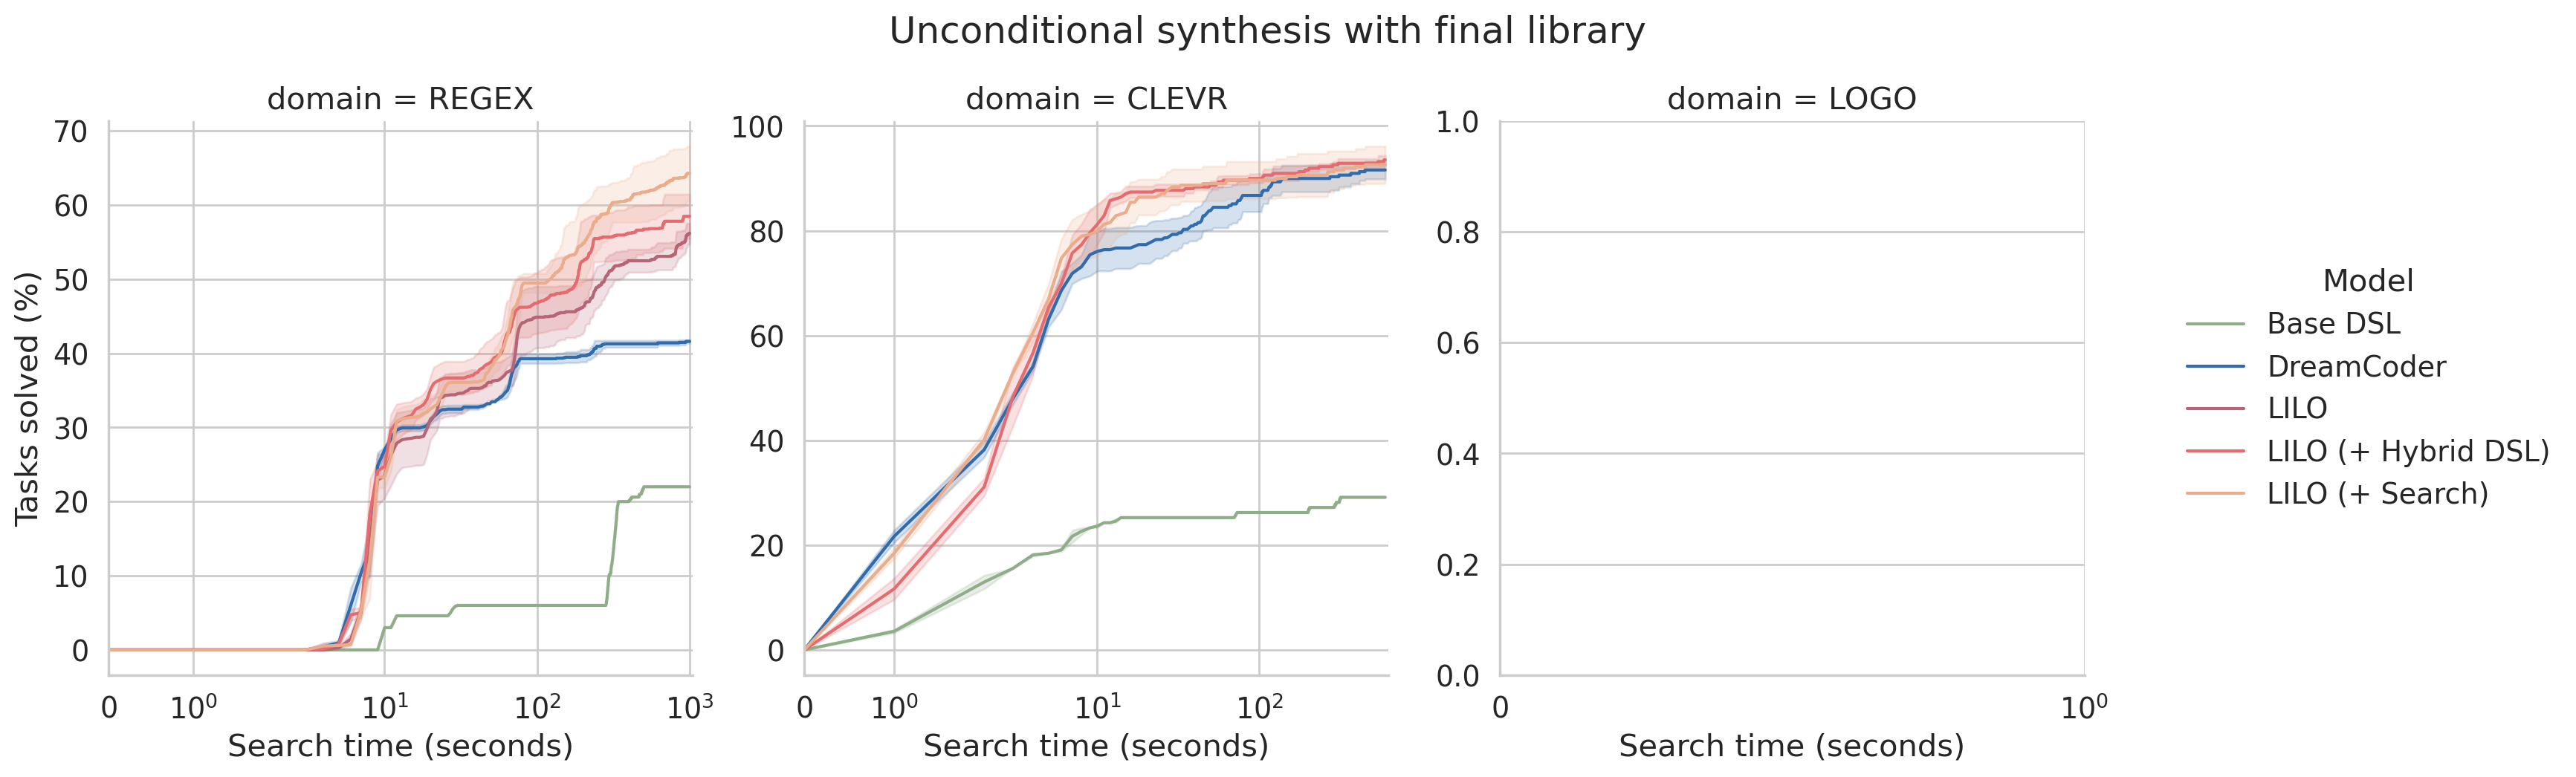

In [28]:
g = sns.relplot(
    data=analyzer.format_dataframe_camera(df_search_time[df_search_time.split == "test"]),
    kind="line",
    col="domain",
    col_order = list(analyzer.DOMAIN_NAMES_CAMERA.values()),
    x="time",
    y=analyzer.COL_NAMES_CAMERA["percent_solved"],
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    legend="full",
    errorbar="se",
    facet_kws={'sharex': False, 'sharey': False, 'margin_titles': True},
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
)

for ax in g.axes[0]:
    ax.set(xscale='symlog', xlim=(0., None), xlabel="Search time (seconds)")

plt.suptitle(f"Unconditional synthesis with final library", y=1.05);

plt.savefig(os.path.join(FIGURES_DIR, "unconditional_synthesis.pdf"), dpi=300, bbox_inches="tight");